In [1]:
%pdb off

Automatic pdb calling has been turned OFF


In [2]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import copy
from sklearn.model_selection import train_test_split


# for importing data
import torchvision

import matplotlib.pyplot as plt

from typing import Tuple, Sequence, List, Optional


In [3]:
import logging

# Configure logging
logging.basicConfig(
    level=logging.DEBUG,              # change to DEBUG for more details
    format="%(asctime)s [%(levelname)s] %(message)s",
    datefmt="%H:%M:%S"
)

In [4]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Import and inspect the data

In [5]:
# download the dataset
cdata = torchvision.datasets.EMNIST(root='emnist',split='letters',download=True)

# more info: https://www.nist.gov/itl/products-and-services/emnist-dataset

100%|██████████| 562M/562M [00:04<00:00, 136MB/s] 


In [6]:
# inspect the data

# the categories (but how many letters??)
print(cdata.classes)
print(str(len(cdata.classes)) + ' classes')

print('\nData size:')
print(cdata.data.shape)

# transform to 4D tensor for conv layers (and transform from int8 to float)
images = cdata.data.unsqueeze(dim=1).float()
print('\nTensor data:')
print(images.shape)

print('\nTarget data:')
print(torch.unique(cdata.targets))

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27 classes

Data size:
torch.Size([124800, 28, 28])

Tensor data:
torch.Size([124800, 1, 28, 28])

Target data:
tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26])


In [7]:
# so therefore we'll eliminate it and subtract 1 from the original

# remove the first class category
letterCategories = cdata.classes[1:]

# relabel labels to start at 0
labels = copy.deepcopy(cdata.targets)-1
print(labels.shape)

###
print( torch.sum(labels==0) )
torch.unique(labels)

torch.Size([124800])
tensor(4800)


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])

In [8]:
# Normalizing images

images /= torch.max(images)

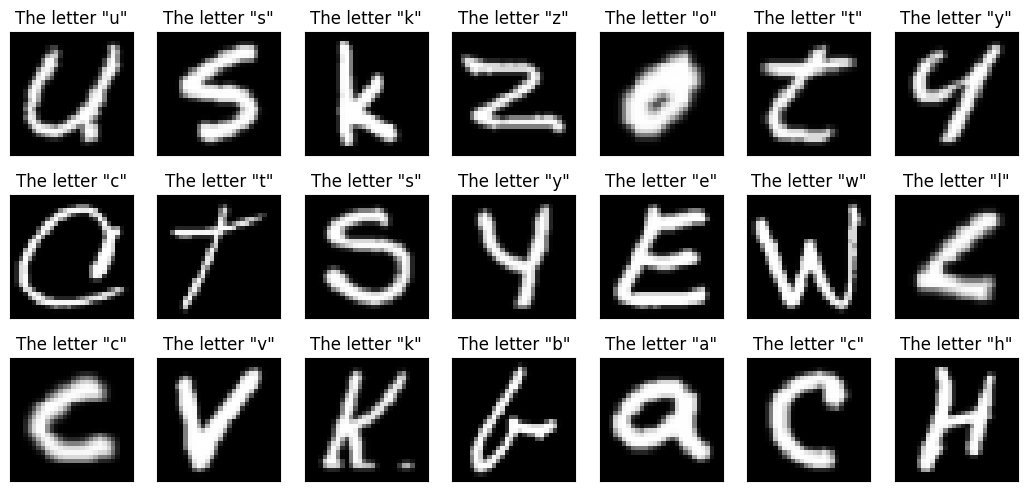

In [9]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):

  # pick a random pic
  whichpic = np.random.randint(images.shape[0])

  # extract the image and its target letter
  I = np.squeeze( images[whichpic,:,:] )
  letter = letterCategories[labels[whichpic]]

  # visualize
  ax.imshow(I.T,cmap='gray')
  ax.set_title('The letter "%s"'%letter)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show();

# Create train/test groups using DataLoader

In [10]:
# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [11]:
# check size (should be images X channels X width X height
print( train_loader.dataset.tensors[0].shape )
print( train_loader.dataset.tensors[1].shape )

torch.Size([112320, 1, 28, 28])
torch.Size([112320])


# Create the DL model

In [12]:
# Helper functions

def _pair(x):
  return x if isinstance(x,(tuple,list)) else (x,x)

def conv2d_out_hw(HW, kernel_size, stride, padding, dilation):
    H, W = HW
    kH, kW = _pair(kernel_size)
    sH, sW = _pair(stride)
    pH, pW = _pair(padding)
    dH, dW = _pair(dilation)

    # Layer[n]-In = floor((Iayer[n-1n]- out + 2*padding - dilation*(kernel-1)-1)/stride + 1)
    outH = np.floor((H + 2*pH - dH*(kH-1) - 1)/sH + 1)
    outW = np.floor((W + 2*pW - dW*(kW-1) - 1)/sW + 1)

    return int(outH), int(outW)

In [ ]:
# create a class for the model

def makeTheNet(imgSize: Tuple[int, int],           #H,W
                in_channels: int = 1,
                out_channels: Sequence[int] = [6,6],         #conv1, conv2
                kernel_size: int | Tuple[int, int]=3,
                stride: int | Tuple[int, int]=1,
                padding: Optional[int | Tuple[int, int]]=1,
                pool_size: Optional[Tuple[int, int]]=(2,2),
                dilation: int | Tuple[int, int]=1,
                groups: int =1,
                bias: bool =True,
                padding_mode: str='zeros',
                cv_dropout: float = 0.0,

                # Defintions for the FC layer
                uLinear: Optional[Sequence[int]] = [50],
                use_batchnorm: bool = False, # Added default value here
                out_size: int = 26,
                ln_dropout: float = 0.0,

                # Regularization
                optimizer = 'Adam',
                weight_decay: float = 0.0,
                lr: float = 1e-3,

                device=None,
                dtype=None,
                printtoggle: bool = False):

  class emnistnet(nn.Module):
    def __init__(self,
                imgSize: Tuple[int, int],           #H,W
                in_channels: int = in_channels,
                out_channels: Sequence[int] = out_channels,     #conv1, conv2
                kernel_size: int | Tuple[int, int]=kernel_size,
                stride: int | Tuple[int, int]=stride,
                padding: Optional[int | Tuple[int, int]]=padding,
                pool_size: Optional[Tuple[int, int]]=pool_size,
                dilation: int | Tuple[int, int]=dilation,
                groups: int =groups,
                bias: bool = bias,
                padding_mode: str=padding_mode,
                cv_dropout: float = cv_dropout,
                # Defintions for the FC layer
                uLinear: Optional[Sequence[int]] = uLinear,
                use_batchnorm: bool = use_batchnorm,
                out_size: int = out_size,
                ln_dropout: float = ln_dropout,
                device=device,
                dtype=dtype,
                printtoggle: bool = printtoggle
                ):
      super().__init__()

      # print toggle
      self.print = printtoggle

      # self.pool = nn.AvgPool2d(pool_size)
      self.pool = nn.MaxPool2d(pool_size)

      self.use_batchnorm = use_batchnorm # Corrected: set the instance variable

      poolH, poolW = _pair(pool_size)

      ### -------------- feature map layers -------------- ###
      # first convolution layer
      self.conv1  = nn.Conv2d(
                              in_channels=1,
                              out_channels=out_channels[0],
                              kernel_size = 3,
                              padding=padding)
      self.bnorm1 = nn.BatchNorm2d(num_features=out_channels[0])

      H1, W1 = conv2d_out_hw(
                                 imgSize,
                                 kernel_size=self.conv1.kernel_size,
                                 stride=self.conv1.stride,
                                 padding=self.conv1.padding,
                                 dilation=self.conv1.dilation
                                       )
      H1p, W1p = H1 //poolH , W1 // poolW  # avg pool


      # second convolution layer
      self.conv2  = nn.Conv2d(
                              in_channels=out_channels[0],
                              out_channels=out_channels[1],
                              kernel_size=3,
                              padding=padding)
      self.bnorm2 = nn.BatchNorm2d(num_features=out_channels[1]) # input the number of channels in this layer

      self.cv_dropout = nn.Dropout2d(cv_dropout)
      self.ln_dropout = nn.Dropout(ln_dropout)


      H2, W2 = conv2d_out_hw(
                                (H1p,W1p),
                                 kernel_size=self.conv2.kernel_size,
                                 stride=self.conv2.stride,
                                 padding=self.conv2.padding,
                                 dilation=self.conv2.dilation
                                       )
      H2p, W2p = H2 // poolH, W2 // poolW  # avg pool

      flat = int(self.conv2.out_channels * H2p * W2p)


      # --- Multi-Layer Perceptorn (MLP) (variable depth) ---
      sizes = list(uLinear) if uLinear is not None else [50]

      self.fcs = nn.ModuleList()

      # Batch normalization for the linear layers
      if self.use_batchnorm: # Corrected: Check the instance variable
        self.fcs_bnorm = nn.ModuleList()
      else:
        self.fcs_bnorm = None

      linearIn = flat
      for h in sizes:
          self.fcs.append(nn.Linear(in_features=linearIn, out_features=h))
          if self.use_batchnorm:
            self.fcs_bnorm.append(nn.BatchNorm1d(num_features=h))
          linearIn = h

      self.output_layer = nn.Linear(linearIn, out_size)

    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),kernel_size=2)
      x = F.leaky_relu(self.bnorm1(x))
      if self.print: print(f'First CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),kernel_size = 2)
      x = F.leaky_relu(self.bnorm2(x))
      x = self.cv_dropout(x)
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # reshape for linear layer
      x = torch.flatten(x,start_dim=1)
      if self.print: print(f'Vectorized: {list(x.shape)}')

      # linear layers
      if self.use_batchnorm:
        for fc, bn in zip(self.fcs, self.fcs_bnorm): # Corrected: Use zip to iterate over both lists
          x = fc(x)
          x = bn(x)               # batch-normalization
          x = F.leaky_relu(x)
      else:
        for fc in self.fcs:
          x = fc(x)
          x = F.leaky_relu(x)
          x = self.ln_dropout(x)


      x = self.output_layer(x)

      return x

  # create the model instance
  net = emnistnet(imgSize, printtoggle=printtoggle, use_batchnorm=use_batchnorm)

  # Move to device/dtype once (constructor kwargs are version-fragile)
  if device is not None or dtype is not None:
      net = net.to(device=device, dtype=dtype)

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = getattr(torch.optim,optimizer)(net.parameters(),lr=lr,weight_decay=weight_decay)

  return net,lossfun,optimizer

In [ ]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet((images.shape[2],images.shape[3]),printtoggle=True, ln_dropout=0.0)

X,y = next(iter(train_loader))
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)

Input: [32, 1, 28, 28]
First CPR block: [32, 6, 14, 14]
Second CPR block: [32, 6, 7, 7]
Vectorized: [32, 294]

Output size:
torch.Size([32, 26])
 
Loss:
tensor(3.2510, grad_fn=<NllLossBackward0>)


# Create a function that trains the model

In [ ]:
# a function that trains the model

def function2trainTheModel( numepochs,
                            imgSize: Tuple[int, int],
                            in_channels: int = 1,
                            out_channels: Sequence[int] = [6,6],
                            kernel_size: int | Tuple[int, int]=3,
                            stride: int | Tuple[int, int]=1,
                            padding: Optional[int | Tuple[int, int]]=1,
                            pool_size: Optional[Tuple[int, int]]=(2,2),
                            dilation: int | Tuple[int, int]=1,
                            groups: int =1,
                            bias: bool =True,
                            padding_mode: str='zeros',
                            cv_dropout: float = 0.0,
                            uLinear: Optional[Sequence[int]] = [50],
                            use_batchnorm: bool = False,
                            out_size: int = 26,
                            ln_dropout: float = 0.0,
                            optimizer = 'Adam',
                            weight_decay: float = 0.0,
                            lr: float = 1e-3,
                            device=None,
                            dtype=None,
                            printtoggle: bool = False
                            ):

  # create a new model
  net,lossfun,optimizer = makeTheNet(imgSize,
                                      in_channels = in_channels,
                                      out_channels = out_channels,
                                      kernel_size = kernel_size,
                                      stride = stride,
                                      padding = padding,
                                      pool_size = pool_size,
                                      dilation = dilation,
                                      groups = groups,
                                      bias = bias,
                                      padding_mode = padding_mode,
                                      cv_dropout = cv_dropout,
                                      uLinear = uLinear,
                                      use_batchnorm = use_batchnorm,
                                      out_size = out_size,
                                      ln_dropout = ln_dropout,
                                      optimizer = optimizer,
                                      weight_decay = weight_decay,
                                      lr = lr,
                                      device=device,
                                      dtype=dtype,
                                      printtoggle = printtoggle
                                    )

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainErr  = torch.zeros(numepochs)
  testErr   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchLoss = []
    batchErr  = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())
      batchErr.append( torch.mean((torch.argmax(yHat,axis=1) != y).float()).item() )
    # end of batch loop...

    # and get average losses and error rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainErr[epochi]  = 100*np.mean(batchErr)



    ### test performance
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)

    # get loss and error rate from the test batch
    testLoss[epochi] = loss.item()
    testErr[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) != y).float()).item()

  # end epochs

  # function output
  return trainLoss,testLoss,trainErr,testErr,net

# Run the model and show the results!

In [ ]:
ln_dropout = 0.0
cv_dropout = 0.2
imgSize = (images.shape[2],images.shape[3])
use_batchnorm = False
weight_decay = 0.0000
trainLoss,testLoss,trainErr,testErr,net = function2trainTheModel(10,imgSize,use_batchnorm,ln_dropout=ln_dropout, cv_dropout=cv_dropout,weight_decay=weight_decay)

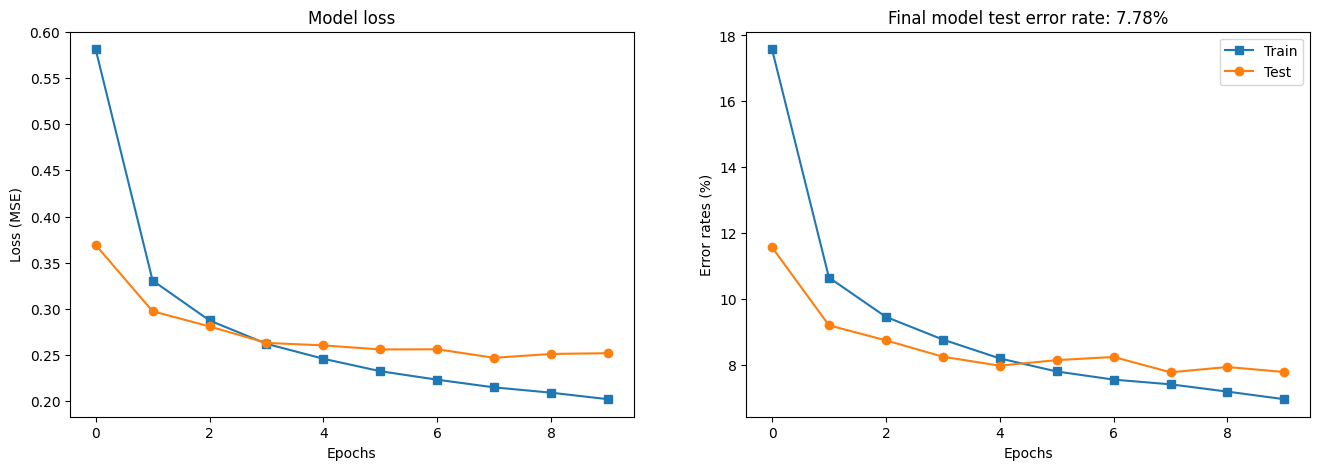

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainErr,'s-',label='Train')
ax[1].plot(testErr,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model test error rate: {testErr[-1]:.2f}%')
ax[1].legend()

plt.show()

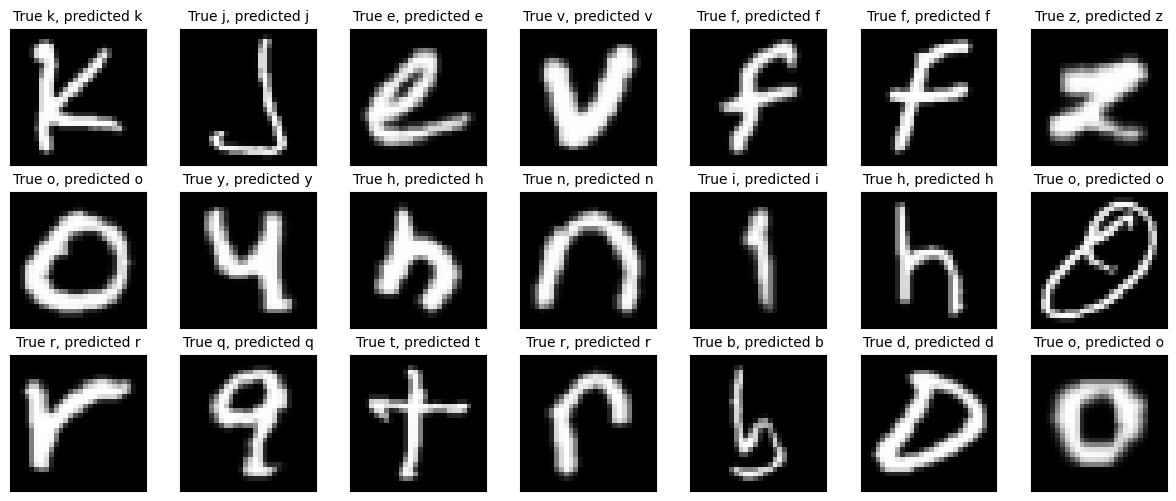

In [ ]:
### visualize some images

# extract X,y from test dataloader
X,y = next(iter(test_loader))
X = X.to(device) # push data to GPU
y = y.to(device) # push data to GPU

# Ensure the model is on the correct device
net = net.to(device)

yHat = net(X)

# pick some examples at random to show
randex = np.random.choice(len(y),size=21,replace=False)

# visualize some images
fig,axs = plt.subplots(3,7,figsize=(15,6))

for i,ax in enumerate(axs.flatten()):

  # extract the image and its target letter
  I = np.squeeze( X[randex[i],0,:,:] ).cpu() # .cpu() to transfer back from GPU!
  trueLetter = letterCategories[ y[randex[i]] ]
  predLetter = letterCategories[ torch.argmax(yHat[randex[i],:]) ]

  # color-code the accuracy (using ternary operator)
  col = 'gray' if trueLetter==predLetter else 'hot'

  # visualize
  ax.imshow(I.T,cmap=col)
  ax.set_title('True %s, predicted %s' %(trueLetter,predLetter),fontsize=10)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

# Accuracy by letter

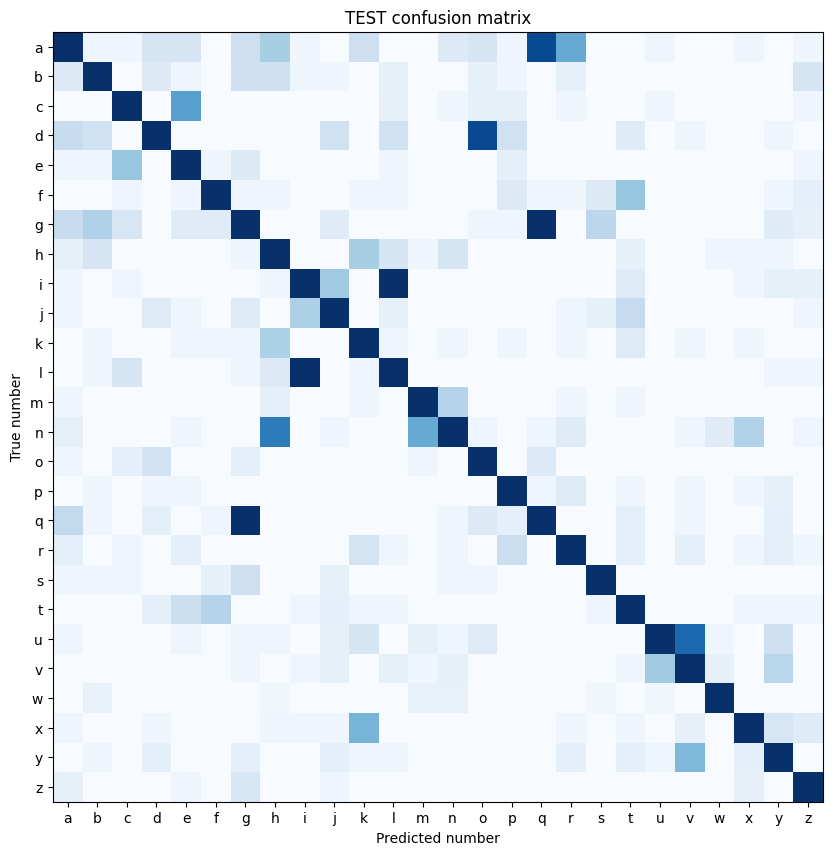

In [ ]:
import sklearn.metrics as skm

# compute the confusion matrix
C = skm.confusion_matrix(y.cpu(),torch.argmax(yHat.cpu(),axis=1),normalize='true')

# visualize it
fig = plt.figure(figsize=(10,10))
plt.imshow(C,'Blues',vmax=.05)

# make the plot look nicer
plt.xticks(range(26),labels=letterCategories)
plt.yticks(range(26),labels=letterCategories)
plt.title('TEST confusion matrix')
plt.xlabel('True number')
plt.xlabel('Predicted number')
plt.ylabel('True number')

plt.show()